---

## 06 - Investigating the DFT
In this notebook, we investigate the DFT by first undertaking a simple example and then exploring an variety of DFT topics. These include DFT periodicity and symmetry, positive and negative frequencies, frequency representation, spectral leakage, windowing, scalloping loss, and zero padding.

## Table of Contents
* [1. Introduction](#introduction)
* [2. An Example of the DFT](#an_example_of_the_dft)
* [3. Magnitude and Phase](#magnitude_and_phase)
* [4. Plotting the DFT](#plotting_the_dft)
* [5. Positive and Negative Frequencies](#symmetry_and_periodicity)
* [6. Magnitude, Power, and the Logarithmic Scale](#magnitude_power_log)
* [7. Frequency Bins and Spectral Resolution](#frequency_bins)
* [8. Spectral Leakage](#spectral_leakage)
* [9. Windowing](#windowing)
* [10. Scalloping Loss](#scalloping_loss)
* [11. Zero Padding](#zero_padding)

## References
* [1] - [f. j. harris, "On the use of windows for harmonic analysis with the discrete Fourier transform," Proceedings of the IEEE, Vol. 66, No. 1, Jan. 1978, pp. 51-83.](https://doi.org/10.1109/PROC.1978.10837)

---


## 1. Introduction <a class="anchor" id="introduction"></a>
We will begin by creating a discrete waveform that we can use as test stimulus for the DFT. Below, we define the regular sampling period $t_s$ and the number of discrete samples $N$.

In [1]:
import numpy as np

fs = 48e3 # Sampling frequency
ts = 1/fs # Regular sampling period
N = 16    # Number of samples
n = np.arange(N) # Sample points

Now we can create two cosine waves that we will add together to produce the final test waveform.

Waveform $a$ has a frequency of 3kHz and waveform $b$ has a frequency of 9kHz.

$$
a(n) = \frac{1}{2}\cos(2\pi 3000 n t_s + \pi/4) 
$$

$$
b(n) = \cos(2\pi 9000 n t_s)
$$

In [2]:
a = 0.5*np.cos(2*np.pi*3e3*n*ts + np.pi/4)
b = np.cos(2*np.pi*9e3*n*ts)

Adding each cosine wave together produces $x(n)$.

$$
x(n) = \frac{1}{2}\cos(2\pi 3000 n t_s + \pi/4) + \cos(2\pi 9000 n t_s)
$$

We can print each unique sample in $x(n)$ as below.

In [3]:
x = np.around(a + b, 4)
for i in range(0, N):
    print(''.join(['x(', str(i), ') = ', str(x[i])]))

x(0) = 1.3536
x(1) = 0.574
x(2) = -0.7071
x(3) = -1.1152
x(4) = -0.3536
x(5) = 0.4619
x(6) = 0.2071
x(7) = -0.8446
x(8) = -1.3536
x(9) = -0.574
x(10) = 0.7071
x(11) = 1.1152
x(12) = 0.3536
x(13) = -0.4619
x(14) = -0.2071
x(15) = 0.8446


Throughout this notebook, we will plot data using the `stem_plot` function below. This function will save a lot of notebook space and reduce code complexity.

In [4]:
import matplotlib.pyplot as plt

def stem_plot(x, y, title, xlabel, ylabel, xticks=None, yticks=None, figsize=(6, 3), subplot=(1, 1), bottom=None, style=None):
    fig = plt.figure(figsize=figsize)
    for idx, value in enumerate(y):
        axes = fig.add_subplot(subplot[0], subplot[1], idx+1)
        if bottom is not None:
            axes.stem(x[idx], y[idx], use_line_collection = True, bottom=bottom[idx])
        else:
            axes.stem(x[idx], y[idx], use_line_collection = True)
        if style is not None:
            if style[idx] == 'dashed':
                axes.plot(x[idx], y[idx], linestyle='dashed')
        axes.grid(True, which='major')
        if xticks is not None:
            axes.set_xticks(xticks[idx])
        if yticks is not None:
            axes.set_yticks(yticks[idx])
        axes.set_title(title[idx])
        axes.set_xlabel(xlabel[idx])
        axes.set_ylabel(ylabel[idx])
        plt.box(False)

We can plot $x(n)$ using the `stem_plot` function.

/var/folders/y_/4y9gzpnx6xx2bxstv0jtcl9h0000gn/T/ipykernel_12749/4018461594.py:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes.stem(x[idx], y[idx], use_line_collection = True)


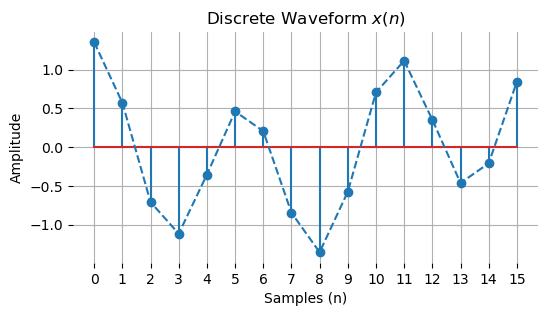

In [5]:
stem_plot(x      = [n],
          y      = [x],
          xticks = [n], 
          figsize= (6, 3),
          title  = ["Discrete Waveform $x(n)$"], 
          style  = ["dashed"], 
          xlabel = ["Samples (n)"], 
          ylabel = ["Amplitude"])

## 2. An Example of the DFT <a class="anchor" id="an_example_of_the_dft"></a>
We can use the DFT to obtain the frequency content of a discrete waveform. The DFT equation is given below.

$$
X(k)=\sum_{n=0}^{N-1}x(n)e^{-2\pi kn/N}
$$

For a discrete input waveform $x(n)$ of length $N$, the DFT will output a discrete waveform $X(k)$ of the same length. Begin by initialising the output vector to zero.

In [6]:
X = np.zeros(N, dtype=np.complex64)

We can now compute the first output value $X(0)$, which corresponds to the DC offset or 0Hz component of $x(n)$.

$$
X(0) = \sum_{n=0}^{15}x(n)e^{-2\pi\cdot 0 \cdot n/16} = \sum_{n=0}^{15}x(n)
$$

In [7]:
X[0] = np.sum(x)
print(''.join(['X(0) = ', str(np.round(X[0], 2))]))

X(0) = 0j


Since $x(n)$ does not have a DC offset, $X(0)$ is equal to zero. Now, calculate the second output value $X(1)$, which corresponds to a frequency component of 3kHz. We should expect this value to be non zero as our input waveform $x(n)$ contains a 3kHz cosine wave.

$$
X(1) = \sum_{n=0}^{15}x(n)e^{-2\pi \cdot 1 \cdot n/16}
$$

In [8]:
X[1] = np.sum(x*np.exp(-2j*np.pi*1*n/N))
print(''.join(['X(1) = ', str(np.round(X[1], 2))]))

X(1) = (2.83+2.83j)


We continue by computing the third output value $X(2)$. This component corresponds to a frequency of 6kHz and should be equal to zero.

$$
X(2) = \sum_{n=0}^{15}x(n)e^{-2\pi \cdot 2 \cdot n/16}
$$

In [9]:
X[2] = np.sum(x*np.exp(-2j*np.pi*2*n/N))
print(''.join(['X(2) = ', str(np.round(X[2], 2))]))

X(2) = -0j


The fourth output value $X(3)$ that corresponds to 9kHz should be more than zero as $x(n)$ contains a 9kHz cosine wave. This is computed as follows.
$$
X(3) = \sum_{n=0}^{15}x(n)e^{-2\pi \cdot 3 \cdot n/16}
$$

In [10]:
X[3] = np.sum(x*np.exp(-2j*np.pi*3*n/N))
print(''.join(['X(3) = ', str(np.round(X[3], 2))]))

X(3) = (8-0j)


Rather than compute each value in $X(k)$, we can use a function to automate the process. We will name the function `dft` and use it throughout this notebook to compute the DFT as required.

In [11]:
def dft(x):
    N = np.size(x)
    X = np.zeros(N, dtype=np.complex64)
    n = np.arange(0, N)
    for k in range(N):
        X[k] = np.sum(x*np.exp(-2j*np.pi*k*n/N))
    return X

Now, compute the DFT of $x(n)$ and print the results for inspection.

In [12]:
X = np.round(dft(x), 2) + (0.0 + 0.0j) # Add 0.0+0.0j to remove -0.0-0.0j
for i in range(N):
    print(''.join(['X(',str(i),') = ',str(X[i])]))

X(0) = 0j
X(1) = (2.83+2.83j)
X(2) = 0j
X(3) = (8+0j)
X(4) = 0j
X(5) = 0j
X(6) = 0j
X(7) = 0j
X(8) = 0j
X(9) = 0j
X(10) = 0j
X(11) = 0j
X(12) = 0j
X(13) = (8+0j)
X(14) = 0j
X(15) = (2.83-2.83j)


As shown, there appears to be symmetry in the results printed above. For instance, $|X(1)| = |X(15)|$ and $|X(3)| = |X(13)|$. We can plot the results in the following sections to aid our understanding of the DFT output.

## 3. Magnitude and Phase <a class="anchor" id="magnitude_and_phase"></a>
We can obtain the real and imaginary components of the DFT output by using the equations below.

$$
\text{Re}(c) = \frac{c + \overline{c}}{2}
$$

$$
\text{Im}(c) = \frac{c - \overline{c}}{2j}
$$

The magnitude of the DFT output can then be obtained using,

$$
|X(k)| = \sqrt{\text{Re}(X(k))^{2}+\text{Im}(X(k))^2}.
$$

We can simply compute the magnitude of a complex vector using `np.abs`. Then, round the vector to two decimal places.

In [13]:
Xm = np.round(np.abs(X), 2)

We will plot the magnitude in a moment. We can also obtain the phase of the DFT output as,

$$
X_{\text{Ø}}(k) = \tan^{-1}\left(\frac{\text{Im}(X(k))}{\text{Re}(X(k))}\right).
$$

This calculation can be performed using `np.angle` (also rounding the output to two decimal places).

In [14]:
Xp = np.round(np.angle(X, deg=True), 2)

The DFT output obtained in the previous section can now be represented in terms of its magnitude and phase. These values can be plotted for inspection. Again, you will notice symmetry in the output result.

In [15]:
for i in range(0, N):
    print(''.join(['X(',str(i),') = ',str(Xm[i]),' ∠ ',str(Xp[i]),'°']))

X(0) = 0.0 ∠ 0.0°
X(1) = 4.0 ∠ 45.0°
X(2) = 0.0 ∠ 0.0°
X(3) = 8.0 ∠ 0.0°
X(4) = 0.0 ∠ 0.0°
X(5) = 0.0 ∠ 0.0°
X(6) = 0.0 ∠ 0.0°
X(7) = 0.0 ∠ 0.0°
X(8) = 0.0 ∠ 0.0°
X(9) = 0.0 ∠ 0.0°
X(10) = 0.0 ∠ 0.0°
X(11) = 0.0 ∠ 0.0°
X(12) = 0.0 ∠ 0.0°
X(13) = 8.0 ∠ 0.0°
X(14) = 0.0 ∠ 0.0°
X(15) = 4.0 ∠ -45.0°


## 4. Plotting the DFT <a class="anchor" id="plotting_the_dft"></a>
Plotting the DFT output is a very useful when analysing the frequency content of a discrete waveform. The real and imaginary components of $X(k)$ can be plotted as below.

/var/folders/y_/4y9gzpnx6xx2bxstv0jtcl9h0000gn/T/ipykernel_12749/4018461594.py:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes.stem(x[idx], y[idx], use_line_collection = True)


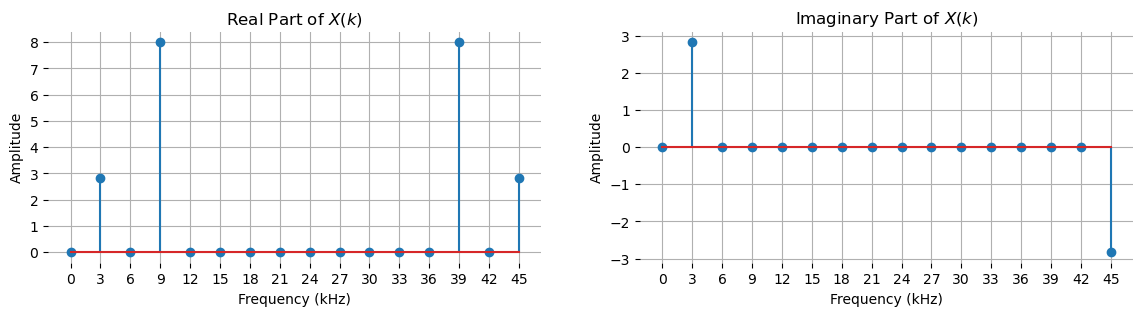

In [16]:
stem_plot(x      = [n*(fs/N)/1e3, n*(fs/N)/1e3],
          y      = [np.real(X), np.imag(X)],
          yticks = [np.arange(0, 9), np.arange(-3, 4)],
          figsize= (14, 3),
          xticks = [n*(fs/N)/1e3, n*(fs/N)/1e3], 
          subplot= (1, 2),
          title  = ["Real Part of $X(k)$", "Imaginary Part of $X(k)$"],
          xlabel = ["Frequency (kHz)", "Frequency (kHz)"], 
          ylabel = ["Amplitude", "Amplitude"])

Symmetry is apparent around the y-axis in the plot showing the real part of $X(k)$ (excluding the 0kHz component). Similarly, we can also see that the imaginary part of $X(k)$ is almost symmetric about the 24kHz (again ignoring the 0KHz component).

We can also plot the magnitude and phase of $X(k)$ that we computed in the previous section.

/var/folders/y_/4y9gzpnx6xx2bxstv0jtcl9h0000gn/T/ipykernel_12749/4018461594.py:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes.stem(x[idx], y[idx], use_line_collection = True)


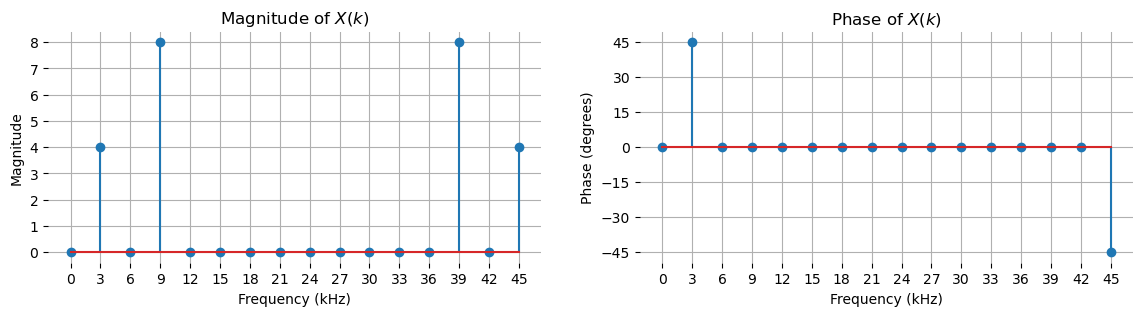

In [17]:
stem_plot(x      = [n*(fs/N)/1e3, n*(fs/N)/1e3],
          y      = [Xm, Xp],
          yticks = [np.arange(0, 9), np.arange(-45, 60, 15)],
          figsize= (14, 3),
          xticks = [n*(fs/N)/1e3, n*(fs/N)/1e3], 
          subplot= (1, 2),
          title  = ["Magnitude of $X(k)$", "Phase of $X(k)$"],
          xlabel = ["Frequency (kHz)", "Frequency (kHz)"], 
          ylabel = ["Magnitude", "Phase (degrees)"])

We can normalise the output magnitude of $X(k)$ by dividing it by $N$. Note, that this technique only works for rectangular windows (discussed later).

$$
X'(k) = \frac{1}{N}\sum_{n=0}^{N-1}x(n)e^{-j2\pi kn/N}
$$

/var/folders/y_/4y9gzpnx6xx2bxstv0jtcl9h0000gn/T/ipykernel_12749/4018461594.py:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes.stem(x[idx], y[idx], use_line_collection = True)


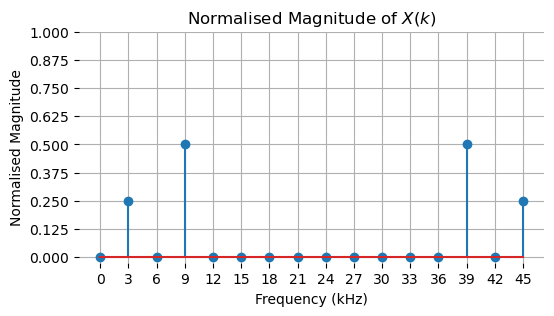

In [18]:
Xnorm = (Xm/N)

stem_plot(x      = [n*(fs/N)/1e3],
          y      = [Xnorm],
          figsize= (6, 3),
          yticks = [np.arange(0, 1.125, 0.125)],
          xticks = [n*(fs/N)/1e3],
          title  = ["Normalised Magnitude of $X(k)$"],
          xlabel = ["Frequency (kHz)"], 
          ylabel = ["Normalised Magnitude"])

Notice that the normalised magnitude frequency spectrum above contains lobes at 3kHz and 9kHz, which corresponds with the original cosine waveforms in $x(n)$. However, the value of the 3kHz lobe is 0.25 and the 9kHz lobe is 0.5. This problem can be resolved by considering positive and negative frequencies, and the periodicity of the DFT in the following section.

## 5. Positive and Negative Frequencies <a class="anchor" id="symmetry_and_periodicity"></a>
All real waveforms have a positive and negative complex exponential of the same frequency. For example, we can use Euler's formula to describe $x(n)$ using complex exponentials.

$$
x(n) = \frac{1}{2}\left(\frac{e^{j2\pi 3000 n t_s + \pi/4} + e^{-j2\pi 3000 n t_s + \pi/4}}{2}\right) + \left(\frac{e^{j2\pi 9000 n t_s} + e^{-j2\pi 9000 n t_s}}{2}\right)
$$

Rearranging the equation above so that positive and negative complex exponentials are paired together gives,

$$
x(n) = \frac{1}{4}e^{j2\pi 3000 n t_s + \pi/4} + \frac{1}{2}e^{j2\pi 9000 n t_s} + \frac{1}{4}e^{-j2\pi 3000 n t_s + \pi/4} + \frac{1}{2}e^{-j2\pi 9000 n t_s}.
$$

Plotting the frequencies of the complex exponentials against their amplitude produces the following.

/var/folders/y_/4y9gzpnx6xx2bxstv0jtcl9h0000gn/T/ipykernel_12749/4018461594.py:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes.stem(x[idx], y[idx], use_line_collection = True)


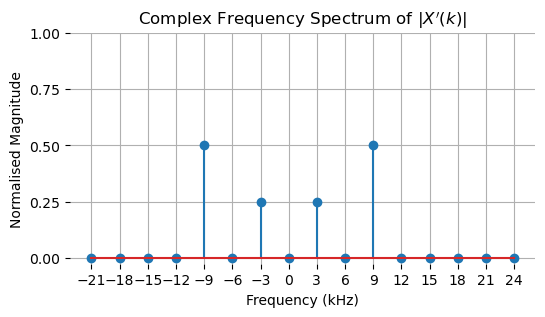

In [19]:
stem_plot(x      = [(n-N/2+1)*(fs/N)/1e3],
          y      = [np.concatenate((Xnorm[N//2+1:N], Xnorm[0:N//2+1]))],
          figsize= (6, 3),
          yticks = [np.arange(0, 1.25, 0.25)],
          xticks = [(n-N/2+1)*(fs/N)/1e3],
          title  = ["Complex Frequency Spectrum of $|X\'(k)|$"],
          xlabel = ["Frequency (kHz)"], 
          ylabel = ["Normalised Magnitude"])

Notice that the plot above is similar to the normalised magnitude of $X(k)$ in the previous section. However, this plot shows positive and negative frequency components. We can sum the positive and negative components together to obtain a real waveform. For instance, let us demonstrate this process using the 9kHz cosine wave from before.

In [20]:
positive_exp = (1/2) * np.exp(2j*np.pi*9000*n*ts)
negative_exp = (1/2) * np.exp(-2j*np.pi*9000*n*ts)
real_waveform = positive_exp + negative_exp

Now present the complex exponentials and their output sum using 3-dimensional complex plots.

/var/folders/y_/4y9gzpnx6xx2bxstv0jtcl9h0000gn/T/ipykernel_12749/2799783956.py:20: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axes.dist = 12


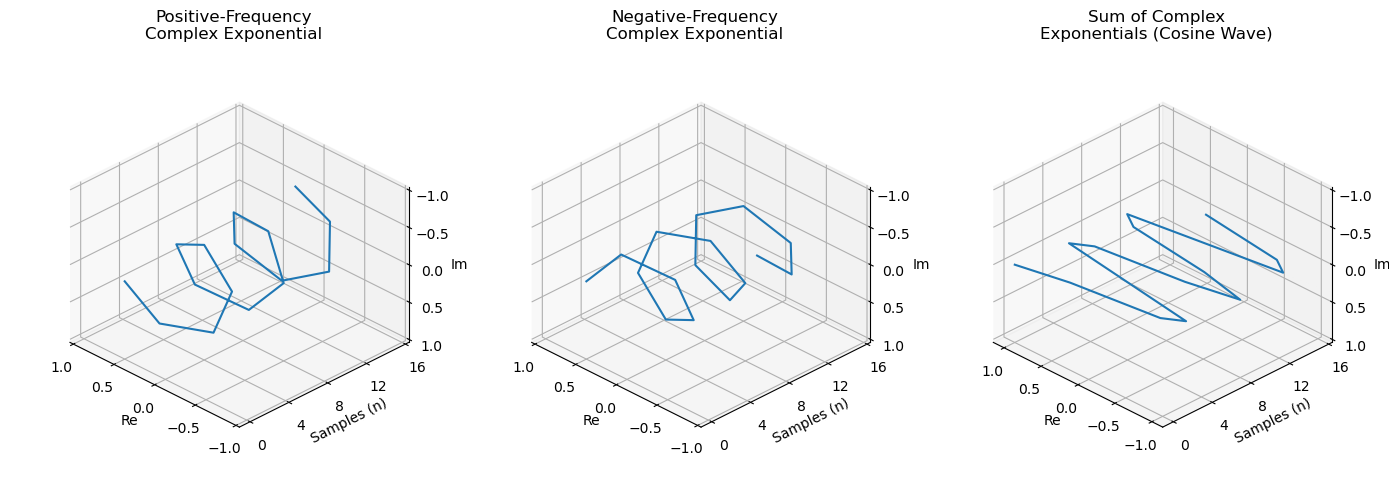

In [21]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14,5))
title = ['Positive-Frequency\nComplex Exponential',
         'Negative-Frequency\nComplex Exponential',
         'Sum of Complex\nExponentials (Cosine Wave)']

for idx, value in enumerate([positive_exp, negative_exp, real_waveform]):
    axes = fig.add_subplot(1,3,idx+1, projection='3d')
    axes.plot(np.real(value), n, np.imag(value))
    axes.set_proj_type('ortho')
    axes.set_xticks(np.arange(-1, 1.5, 0.5))
    axes.set_zticks(np.arange(-1, 1.5, 0.5))
    axes.set_yticks(np.arange(0, N+1, N/4))
    axes.set_xlabel('Re')
    axes.set_ylabel('Samples (n)')
    axes.set_zlabel('Im')
    axes.set_title(title[idx])
    axes.view_init(-150, 45)
    axes.dist = 12
    
fig.tight_layout()

The plots above show the positive-frequency complex exponential rotating in one direction, and the negative-frequency complex exponential rotating in the other direction. The sum of these complex exponential produces the original 9kHz real valued waveform.

Negative frequencies are possible if we consider the periodicity of the DFT using the equation below.

$$
X(k) = X(k+N) = \sum_{n=0}^{N-1}x(n)e^{-j2\pi kn/N}
$$

We can compute the DFT when $k$ operates across the range $[-16, 15]$ and compare the results.

In [22]:
for i in range(N):
    temp = np.round(np.sum(x*np.exp(-2j*np.pi*i*n/N)), 2) + (0.0 + 0.0j)
    temp_N = np.round(np.sum(x*np.exp(-2j*np.pi*(i-N)*n/N)), 2) + (0.0 + 0.0j)
    print('{:s}{:d}{:2s}{:2s}{:.2f}{:>4s}{:d}{:2s}{:2s}{:.2f}'.format(
        'X(', i-N, ')', '=', temp_N, 'X(', i, ')', '=', temp))

X(-16) = 0.00+0.00j  X(0) = 0.00+0.00j
X(-15) = 2.83+2.83j  X(1) = 2.83+2.83j
X(-14) = 0.00+0.00j  X(2) = 0.00+0.00j
X(-13) = 8.00+0.00j  X(3) = 8.00+0.00j
X(-12) = 0.00+0.00j  X(4) = 0.00+0.00j
X(-11) = 0.00+0.00j  X(5) = 0.00+0.00j
X(-10) = 0.00+0.00j  X(6) = 0.00+0.00j
X(-9) = 0.00+0.00j  X(7) = 0.00+0.00j
X(-8) = 0.00+0.00j  X(8) = 0.00+0.00j
X(-7) = 0.00+0.00j  X(9) = 0.00+0.00j
X(-6) = 0.00+0.00j  X(10) = 0.00+0.00j
X(-5) = 0.00+0.00j  X(11) = 0.00+0.00j
X(-4) = 0.00+0.00j  X(12) = 0.00+0.00j
X(-3) = 8.00+0.00j  X(13) = 8.00+0.00j
X(-2) = 0.00+0.00j  X(14) = 0.00+0.00j
X(-1) = 2.83-2.83j  X(15) = 2.83-2.83j


Notice that the DFT output is periodic every $N$ samples. We normally multiply the output DFT by 2 for real waveforms only and can simply ignore one half of the DFT as it contains redundant data.

It is important to note that complex waveforms do not have a combination of positive and negative complex exponentials. They are characterised by one complex exponential only. Consider the complex wave given by

$$
x(n) = \frac{1}{4}e^{-j2\pi 12000 n t_s}.
$$

We can compute the DFT and plot the results for analysis.

/var/folders/y_/4y9gzpnx6xx2bxstv0jtcl9h0000gn/T/ipykernel_12749/4018461594.py:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes.stem(x[idx], y[idx], use_line_collection = True)


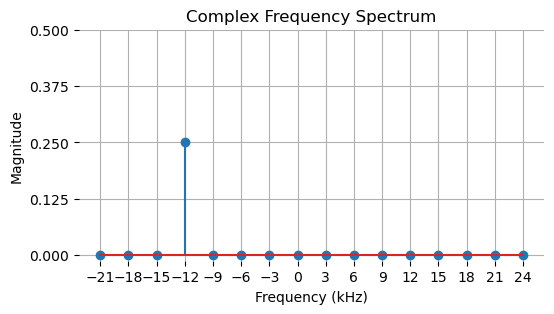

In [23]:
fc = -12e3 # select from -21e3 to 24e3 in multiples of 3e3
cwave = np.round((1/4)*np.exp(2j*np.pi*fc*n*ts), 2)
cwave_fnorm = np.round(np.abs(dft(cwave)), 2)/N
fmag_shift = np.concatenate((cwave_fnorm[N//2+1:N], cwave_fnorm[0:N//2+1]))

stem_plot(x      = [(n-N/2+1)*(fs/N)/1e3],
          y      = [fmag_shift],
          figsize= (6, 3),
          yticks = [np.arange(0, 0.625, 0.125)],
          xticks = [(n-N/2+1)*(fs/N)/1e3],
          title  = ["Complex Frequency Spectrum"],
          xlabel = ["Frequency (kHz)"], 
          ylabel = ["Magnitude"])

Notice that this complex waveform only contains one frequency component in its DFT output.

## 6. Magnitude, Power, and the Logarithmic Scale <a class="anchor" id="magnitude_power_log"></a>
The DFT output can be plotted using several different units and scales. Consider the discrete time domain waveform given below.

/var/folders/y_/4y9gzpnx6xx2bxstv0jtcl9h0000gn/T/ipykernel_12749/4018461594.py:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes.stem(x[idx], y[idx], use_line_collection = True)


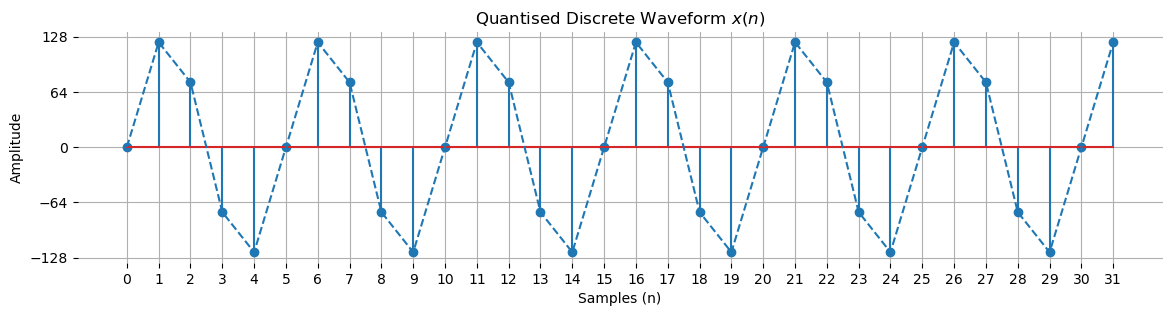

In [24]:
fs = 1000
ts = 1/fs
fd = 200
N = 32
qlevels = 128 # -128 to 127
n = np.arange(0, N)
x = qlevels * np.sin(2*np.pi*fd*ts*n)

stem_plot(x      = [n],
          y      = [x],
          xticks = [n], 
          yticks = [np.arange(-qlevels, qlevels+1, qlevels//2)],
          figsize= (14, 3),
          title  = ["Quantised Discrete Waveform $x(n)$"], 
          style  = ["dashed"], 
          xlabel = ["Samples (n)"], 
          ylabel = ["Amplitude"])

The power spectrum of this discrete waveform can be obtained using,

$$
X'_{\text{ps}}(k)=|X'(k)|^2.
$$

Similarly, we can also represent the power spectrum using a log-scale equivalent, as given below.

$$
X'_{\text{dB}}(k)=20\text{log}_{10}(|X'(k)|) \, \text{dB}
$$

We can plot the power spectrum using the following code cell.

/var/folders/y_/4y9gzpnx6xx2bxstv0jtcl9h0000gn/T/ipykernel_12749/4018461594.py:8: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes.stem(x[idx], y[idx], use_line_collection = True, bottom=bottom[idx])


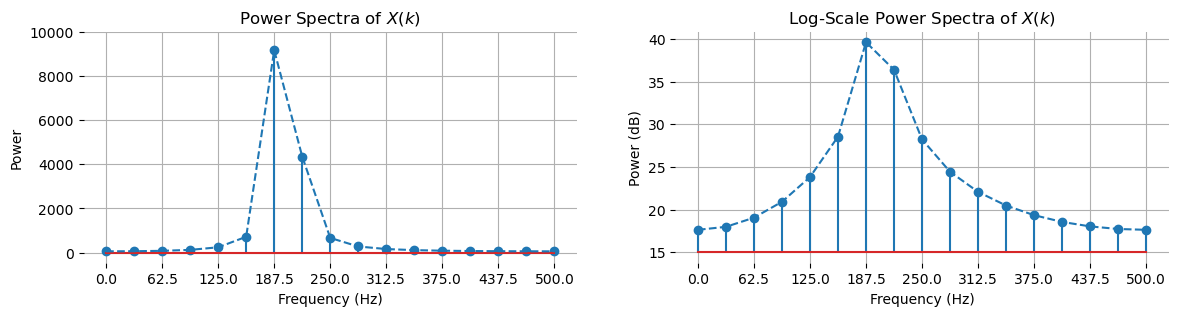

In [25]:
X = np.round(dft(x), 2) + (0.0 + 0.0j) # Add 0.0+0.0j to remove -0.0-0.0j
Xm = np.round(np.abs(X), 2)
Xnorm = (Xm/N)*2 # multiply by 2 as real
Xpow = Xnorm**2  # power calculation
Xlogpow = 20*np.where(Xnorm>0, np.log10(Xnorm), 0) # log scale

stem_plot(x      = [n[0:N//2+1:1]*(fs/N), n[0:N//2+1:1]*(fs/N)],
          y      = [Xpow[0:N//2+1:1], Xlogpow[0:N//2+1:1]],
          subplot= (1, 2),
          figsize= (14, 3),
          bottom = [0, 15],
          style  = ["dashed", "dashed"],
          yticks = [np.arange(0, 10000+1, 2000), np.arange(15, 40+1, 5)],
          xticks = [n[0:N//2+1:2]*fs/N, n[0:N//2+1:2]*fs/N],
          title  = ["Power Spectra of $X(k)$", "Log-Scale Power Spectra of $X(k)$"],
          xlabel = ["Frequency (Hz)", "Frequency (Hz)"], 
          ylabel = ["Power", "Power (dB)"])

It is also possible to use dBFS (decibels relative to full-scale) to represent the power spectrum, which is given as,

$$
X'_{\text{dBFS}}(k)=20\text{log}_{10}\left(\frac{|X'(k)|}{\text{full-scale}}\right) \, \text{dBFS},
$$

where full-scale is the maximum quantisation level of a discrete waveform. We can plot the dBFS representation of the discrete time waveform below.

/var/folders/y_/4y9gzpnx6xx2bxstv0jtcl9h0000gn/T/ipykernel_12749/4018461594.py:8: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes.stem(x[idx], y[idx], use_line_collection = True, bottom=bottom[idx])


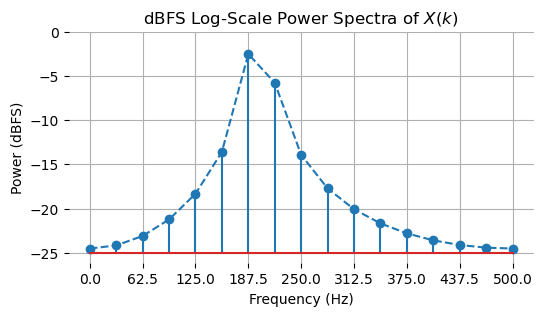

In [26]:
Xdbfs = 20*np.where(Xpow>0, np.log10(Xnorm/qlevels), 0)

stem_plot(x      = [n[0:N//2+1:1]*(fs/N)],
          y      = [Xdbfs[0:N//2+1:1]],
          figsize= (6, 3),
          bottom = [-25],
          yticks = [np.arange(0, -25-1, -5)],
          style  = ["dashed"],
          xticks = [n[0:N//2+1:2]*fs/N],
          title  = ["dBFS Log-Scale Power Spectra of $X(k)$"],
          xlabel = ["Frequency (Hz)"],
          ylabel = ["Power (dBFS)"])

## 7. Frequency Bins and Resolution <a class="anchor" id="frequency_bins"></a>
The frequency axis of the above spectrum plots are divided into several discrete frequencies, which are known as bins. The spacing between the bins is known as the frequency resolution. We can use an example to demonstrate how the DFT length $N$, and the sample frequency $f_s$ affect the frequency resolution of the DFT output.

Consider the discrete sine wave given below, which has a sample frequency of 1000Hz and contains 8 samples. The target frequency of the sine wave is 125Hz.

/var/folders/y_/4y9gzpnx6xx2bxstv0jtcl9h0000gn/T/ipykernel_12749/4018461594.py:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes.stem(x[idx], y[idx], use_line_collection = True)


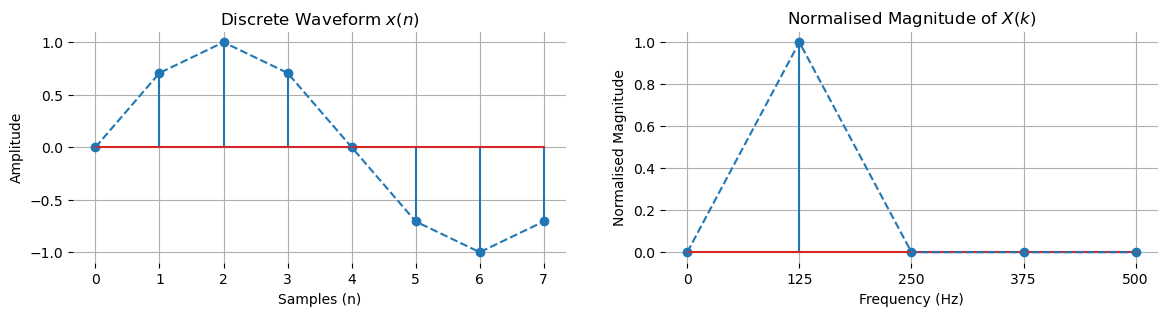

In [27]:
fs = 1000
ts = 1/fs
fd = 125
N = 8
n = np.arange(0, N)
x = np.sin(2*np.pi*fd*ts*n)
X = dft(x)
Xm = np.round(np.abs(X), 2)
Xnorm = (Xm/N)*2 # multiply by 2 as real

stem_plot(x      = [n, n[0:N//2+1:1]*(fs/N)],
          y      = [x, Xnorm[0:N//2+1:1]],
          subplot= (1, 2),
          figsize= (14, 3),
          style  = ["dashed", "dashed"],
          yticks = [np.arange(-1, 1+0.5, 0.5), np.arange(0, 1.2, 0.2)],
          xticks = [n, n[0:N//2+1:1]*fs/N],
          title  = ["Discrete Waveform $x(n)$", "Normalised Magnitude of $X(k)$"],
          xlabel = ["Samples (n)", "Frequency (Hz)"], 
          ylabel = ["Amplitude", "Normalised Magnitude"])

As shown above, the normalised magnitude spectrum consists of 5 evenly spaced frequencies, which are 0Hz, 125Hz, 250Hz, 375Hz, and 500Hz. We can see that the frequency resolution is 125Hz. The frequency resolution, denoted as $\Delta f$ can also be calculated using,

$$
\Delta f = \frac{f_s}{N} = \frac{1000 \text{ samples/second}}{8 \text{ samples}} = 125 \text{ Hz}.
$$

The frequency resolution is affected by the number of samples in the input waveform. For instance, increasing the number of samples such that $N=16$ improves the frequency resolution, as shown below.

/var/folders/y_/4y9gzpnx6xx2bxstv0jtcl9h0000gn/T/ipykernel_12749/4018461594.py:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes.stem(x[idx], y[idx], use_line_collection = True)


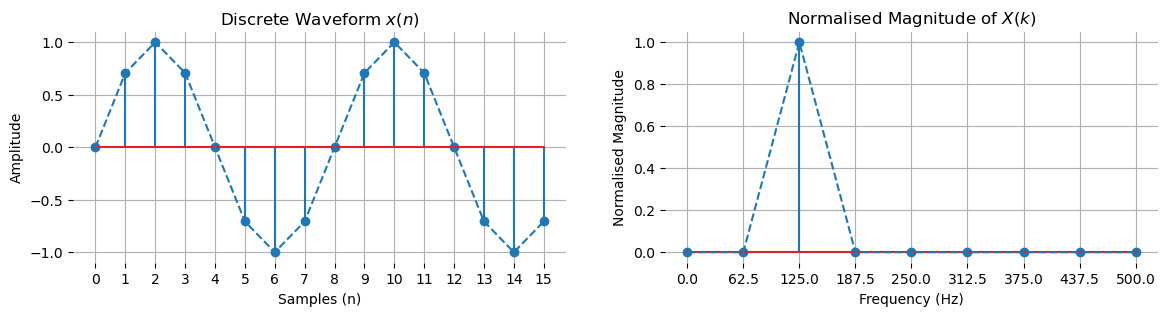

In [28]:
N = 16
n = np.arange(0, N)
x = np.sin(2*np.pi*fd*ts*n)
X = dft(x)
Xm = np.round(np.abs(X), 2)
Xnorm = (Xm/N)*2 # multiply by 2 as real

stem_plot(x      = [n, n[0:N//2+1:1]*(fs/N)],
          y      = [x, Xnorm[0:N//2+1:1]],
          subplot= (1, 2),
          figsize= (14, 3),
          style  = ["dashed", "dashed"],
          yticks = [np.arange(-1, 1+0.5, 0.5), np.arange(0, 1.2, 0.2)],
          xticks = [n, n[0:N//2+1:1]*fs/N],
          title  = ["Discrete Waveform $x(n)$", "Normalised Magnitude of $X(k)$"],
          xlabel = ["Samples (n)", "Frequency (Hz)"], 
          ylabel = ["Amplitude", "Normalised Magnitude"])

Alternatively, the frequency resolution improves if the sample frequency is reduced. For example, the code cell below uses a sample frequency of $f_s=500\text{Hz}$ and $N=8$. Notice that the frequency resolution is now $\Delta f = 62.5\text{Hz}$.

/var/folders/y_/4y9gzpnx6xx2bxstv0jtcl9h0000gn/T/ipykernel_12749/4018461594.py:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes.stem(x[idx], y[idx], use_line_collection = True)


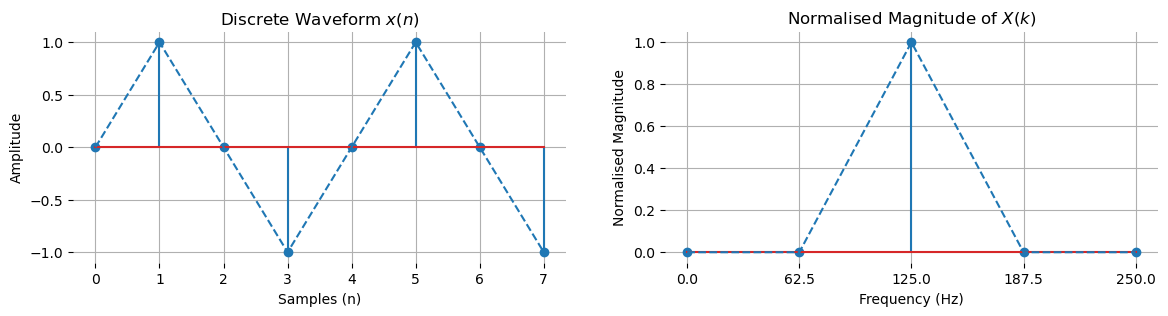

In [29]:
fs = 500
ts = 1/fs
N = 8
n = np.arange(0, N)
x = np.sin(2*np.pi*fd*ts*n)
X = dft(x)
Xm = np.round(np.abs(X), 2)
Xnorm = (Xm/N)*2 # multiply by 2 as real

stem_plot(x      = [n, n[0:N//2+1:1]*(fs/N)],
          y      = [x, Xnorm[0:N//2+1:1]],
          subplot= (1, 2),
          figsize= (14, 3),
          style  = ["dashed", "dashed"],
          yticks = [np.arange(-1, 1+0.5, 0.5), np.arange(0, 1.2, 0.2)],
          xticks = [n, n[0:N//2+1:1]*fs/N],
          title  = ["Discrete Waveform $x(n)$", "Normalised Magnitude of $X(k)$"],
          xlabel = ["Samples (n)", "Frequency (Hz)"], 
          ylabel = ["Amplitude", "Normalised Magnitude"])

We can improve the frequency resolution by decreasing the sample rate and/or increasing the number of samples used by the DFT. However, we must consider the implications of changing these parameters. Increasing the number of samples $N$ means that additional computation is necessary to compute the DFT. Also, decreasing the sample frequency has the effect of reducing the range of frequencies that can be observed.

## 8. Spectral Leakage <a class="anchor" id="spectral_leakage"></a>
The DFT operates very well on discrete waveforms that contain frequency components that are an integer multiple of the frequency resolution (or fundamental frequency). When the input waveform does not fall directly into a DFT bin, spectral leakage occurs. For instance, consider an 80Hz discrete wave that has been sampled at 1000Hz and contains 16 samples. The corresponding DFT does not have a frequency bin for the 80Hz component, therefore, the energy spreads into neighbouring frequencies. This phenomenon is known to cause many people to interpret DFT results incorrectly.

/var/folders/y_/4y9gzpnx6xx2bxstv0jtcl9h0000gn/T/ipykernel_12749/4018461594.py:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes.stem(x[idx], y[idx], use_line_collection = True)


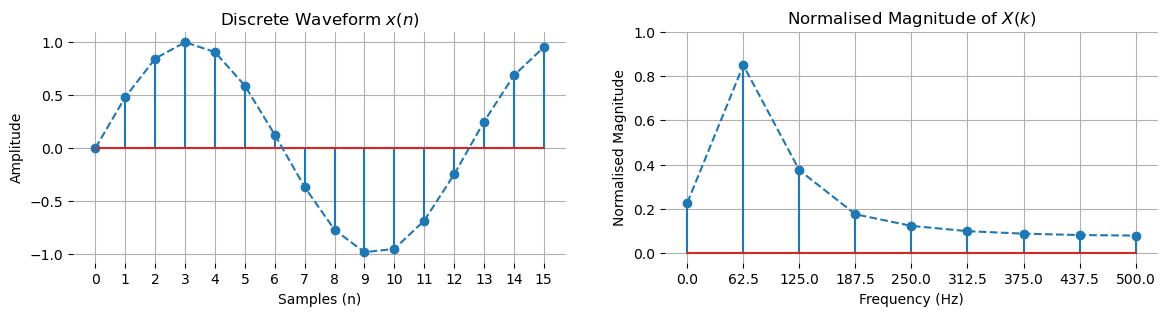

In [30]:
fs = 1000
ts = 1/fs
fd = 80
N = 16
n = np.arange(0, N)
x = np.sin(2*np.pi*fd*ts*n)
X = dft(x)
Xm = np.round(np.abs(X), 2)
Xnorm = (Xm/N)*2 # multiply by 2 as real

stem_plot(x      = [n, n[0:N//2+1:1]*(fs/N)],
          y      = [x, Xnorm[0:N//2+1:1]],
          subplot= (1, 2),
          figsize= (14, 3),
          style  = ["dashed", "dashed"],
          yticks = [np.arange(-1, 1+0.5, 0.5), np.arange(0, 1.2, 0.2)],
          xticks = [n, n[0:N//2+1:1]*fs/N],
          title  = ["Discrete Waveform $x(n)$", "Normalised Magnitude of $X(k)$"],
          xlabel = ["Samples (n)", "Frequency (Hz)"], 
          ylabel = ["Amplitude", "Normalised Magnitude"])

We implicitly assume that the input waveform to the DFT contains pseudo-periods every $N$ samples. In the discrete waveform above, there will be an abrupt transition between one period and another. These abrupt changes in amplitude are known as discontinuities and are only found at the endpoints of a waveform's sampling interval.

It is possible to plot the discrete magnitude response we obtained above, alongside an approximation of the continuous frequency response of the 80Hz sine wave. This can be seen by running the code cell below.

/var/folders/y_/4y9gzpnx6xx2bxstv0jtcl9h0000gn/T/ipykernel_12749/3521651832.py:8: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes.stem(n[0:N//2+1:1]*(fs/N), Xnorm[0:N//2+1:1], use_line_collection=True)


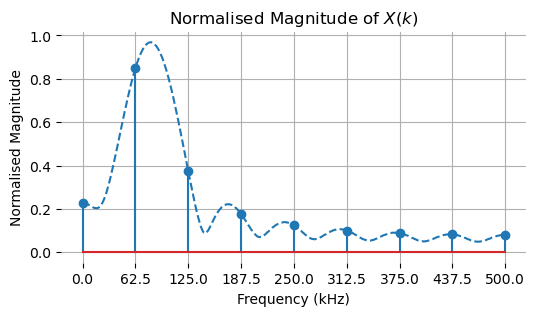

In [31]:
Nc = 1024
Xc = dft(np.pad(x, (0, Nc-N), 'constant'))
Xcm = np.round(np.abs(Xc), 2)
Xcnorm = (Xcm/N)*2 # multiply by 2 as real

fig = plt.figure(figsize=(6, 3))
axes = fig.add_subplot(1, 1, 1)
axes.stem(n[0:N//2+1:1]*(fs/N), Xnorm[0:N//2+1:1], use_line_collection=True)
axes.plot(np.arange(0,Nc//2+1,1)*(fs/Nc), Xcnorm[0:Nc//2+1:1], linestyle='dashed')
axes.grid(True, which='major')
axes.set_title('Normalised Magnitude of $X(k)$')
axes.set_yticks(np.arange(0, 1.2, 0.2))
axes.set_xticks(n[0:N//2+1:1]*fs/N)
axes.set_xlabel('Frequency (kHz)')
axes.set_ylabel('Normalised Magnitude')
plt.box(False)

The main lobe of the continuous frequency response is centred across 80Hz. As shown, the discrete response is simply a sampled version of the continuous frequency magnitude response. Each bin of the discrete response has been given a value that is an equivalent point on the continuous magnitude response.

## 9. Windowing <a class="anchor" id="windowing"></a>
Spectral leakage can be suppressed by windowing a discrete waveform before using the DFT. Windowing is the process of extracting a subset of data from a larger set (extracting an interval of data). Many windows in Digital Signal Processing (DSP) have the effect of "tapering" the endpoints of a discrete waveform to reduce the possibility of abrupt transitions, which cause spectral leakage to occur. We can describe windowing in the DFT equation as below, where $w(n)$ denotes the discrete window.

$$
X_w(k)=\sum_{n=0}^{N-1}w(n) \cdot x(n)e^{-j2\pi kn/N}
$$

In this section, we will briefly exploring windowing. We will begin by creating a test waveform for analysis. The sine wave below has a sampling frequency of 1000Hz, a desired frequency of 80Hz and a sample length of 16.

/var/folders/y_/4y9gzpnx6xx2bxstv0jtcl9h0000gn/T/ipykernel_12749/4018461594.py:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes.stem(x[idx], y[idx], use_line_collection = True)


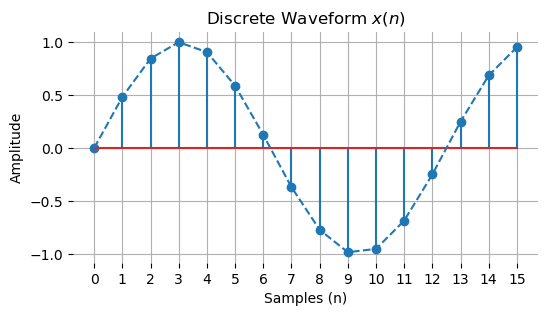

In [32]:
fs = 1000
ts = 1/fs
fd = 80
N = 16
n = np.arange(0, N)
x = np.sin(2*np.pi*fd*ts*n)

stem_plot(x      = [n],
          y      = [x],
          figsize= (6, 3),
          xticks = [n], 
          yticks = [np.arange(-1, 1.5, 0.5)],
          title  = ["Discrete Waveform $x(n)$"], 
          style  = ["dashed"], 
          xlabel = ["Samples (n)"], 
          ylabel = ["Amplitude"])

The simplest form of window is known as a rectangular window, which does not modify (or taper) the extracted data. Rectangular windows are used to extract an interval of data from a discrete waveform. Since the waveform above has not been modified, it has been extracted using a rectangular window of length 16.

A useful window for tapering the endpoints of a discrete waveform is known as a Hanning window. You can see its effects when applied to the data above by running the following code cell.

/var/folders/y_/4y9gzpnx6xx2bxstv0jtcl9h0000gn/T/ipykernel_12749/4018461594.py:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes.stem(x[idx], y[idx], use_line_collection = True)


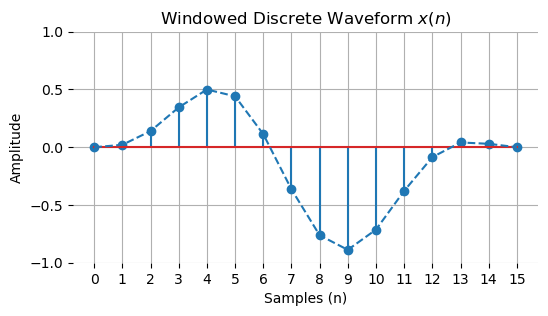

In [33]:
w = np.hanning(N)
xw = x*w

stem_plot(x      = [n],
          y      = [xw],
          figsize= (6, 3),
          xticks = [n], 
          yticks = [np.arange(-1, 1.5, 0.5)],
          title  = ["Windowed Discrete Waveform $x(n)$"], 
          style  = ["dashed"], 
          xlabel = ["Samples (n)"], 
          ylabel = ["Amplitude"])

We can compare the effects of using a rectangular window and Hanning window by observing their corresponding magnitude spectra plots, which are generated using the DFT. Run the code cell below to generate these plots. You will notice that the rectangular window will have a larger amount of spectral leakage than the Hanning window.

/var/folders/y_/4y9gzpnx6xx2bxstv0jtcl9h0000gn/T/ipykernel_12749/4018461594.py:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes.stem(x[idx], y[idx], use_line_collection = True)


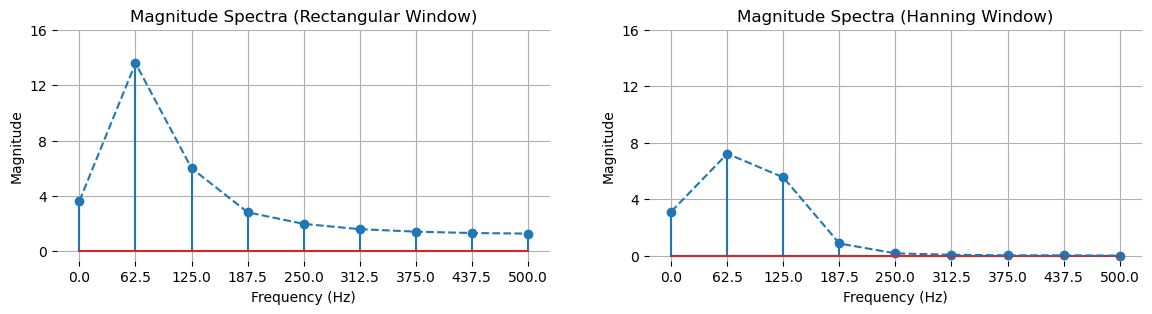

In [34]:
Xm = np.round(np.abs(dft(x)), 2)*2
Xwm = np.round(np.abs(dft(xw)), 2)*2

stem_plot(x      = [n[0:N//2+1:1]*(fs/N), n[0:N//2+1:1]*(fs/N)],
          y      = [Xm[0:N//2+1:1], Xwm[0:N//2+1:1]],
          yticks = [np.arange(0, 20, 4), np.arange(0, 20, 4)],
          figsize= (14, 3),
          style  = ["dashed", "dashed"],
          xticks = [n[0:N//2+1:1]*fs/N, n[0:N//2+1:1]*fs/N], 
          subplot= (1, 2),
          title  = ["Magnitude Spectra (Rectangular Window)",
                    "Magnitude Spectra (Hanning Window)"],
          xlabel = ["Frequency (Hz)", "Frequency (Hz)"], 
          ylabel = ["Magnitude", "Magnitude"])

Although the Hanning window exhibits less spectral leakage than the rectangular window, it has a wider main lobe. We can normalise the effects of windows by dividing the output DFT by the sum of the window, which is given as

$$
X_w'(k)=\frac{1}{\sum_{n}{w(n)}}X_w(k).
$$

Normalising each DFT output by their corresponding window produces the following normalised magnitude spectra plots.

/var/folders/y_/4y9gzpnx6xx2bxstv0jtcl9h0000gn/T/ipykernel_12749/4018461594.py:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes.stem(x[idx], y[idx], use_line_collection = True)


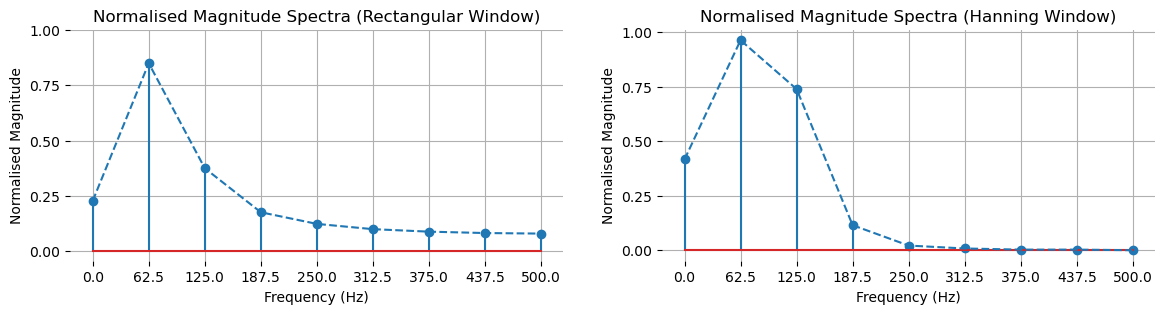

In [35]:
Xnorm = Xm/np.sum(np.ones(N))
Xwnorm = Xwm/np.sum(np.hanning(N))

stem_plot(x      = [n[0:N//2+1:1]*(fs/N), n[0:N//2+1:1]*(fs/N)],
          y      = [Xnorm[0:N//2+1:1], Xwnorm[0:N//2+1:1]],
          yticks = [np.arange(0, 1.25, 0.25), np.arange(0, 1.25, 0.25)],
          figsize= (14, 3),
          style  = ["dashed", "dashed"],
          xticks = [n[0:N//2+1:1]*fs/N, n[0:N//2+1:1]*fs/N], 
          subplot= (1, 2),
          title  = ["Normalised Magnitude Spectra (Rectangular Window)",
                    "Normalised Magnitude Spectra (Hanning Window)"],
          xlabel = ["Frequency (Hz)", "Frequency (Hz)"], 
          ylabel = ["Normalised Magnitude", "Normalised Magnitude"])

It is clear that tapering the endpoints of a discrete waveform before it undergoes the DFT is useful to suppress spectral leakage. Using a non-rectangular window to taper a discrete waveform's endpoints always has the effect of increasing the width of the primary lobe.

We can plot many different windows from the Numpy Python library using the code cell below.

/var/folders/y_/4y9gzpnx6xx2bxstv0jtcl9h0000gn/T/ipykernel_12749/2829883841.py:16: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes.stem(n, w(N), use_line_collection=True)
/var/folders/y_/4y9gzpnx6xx2bxstv0jtcl9h0000gn/T/ipykernel_12749/2829883841.py:12: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes.stem(n, w(N+1), use_line_collection=True)


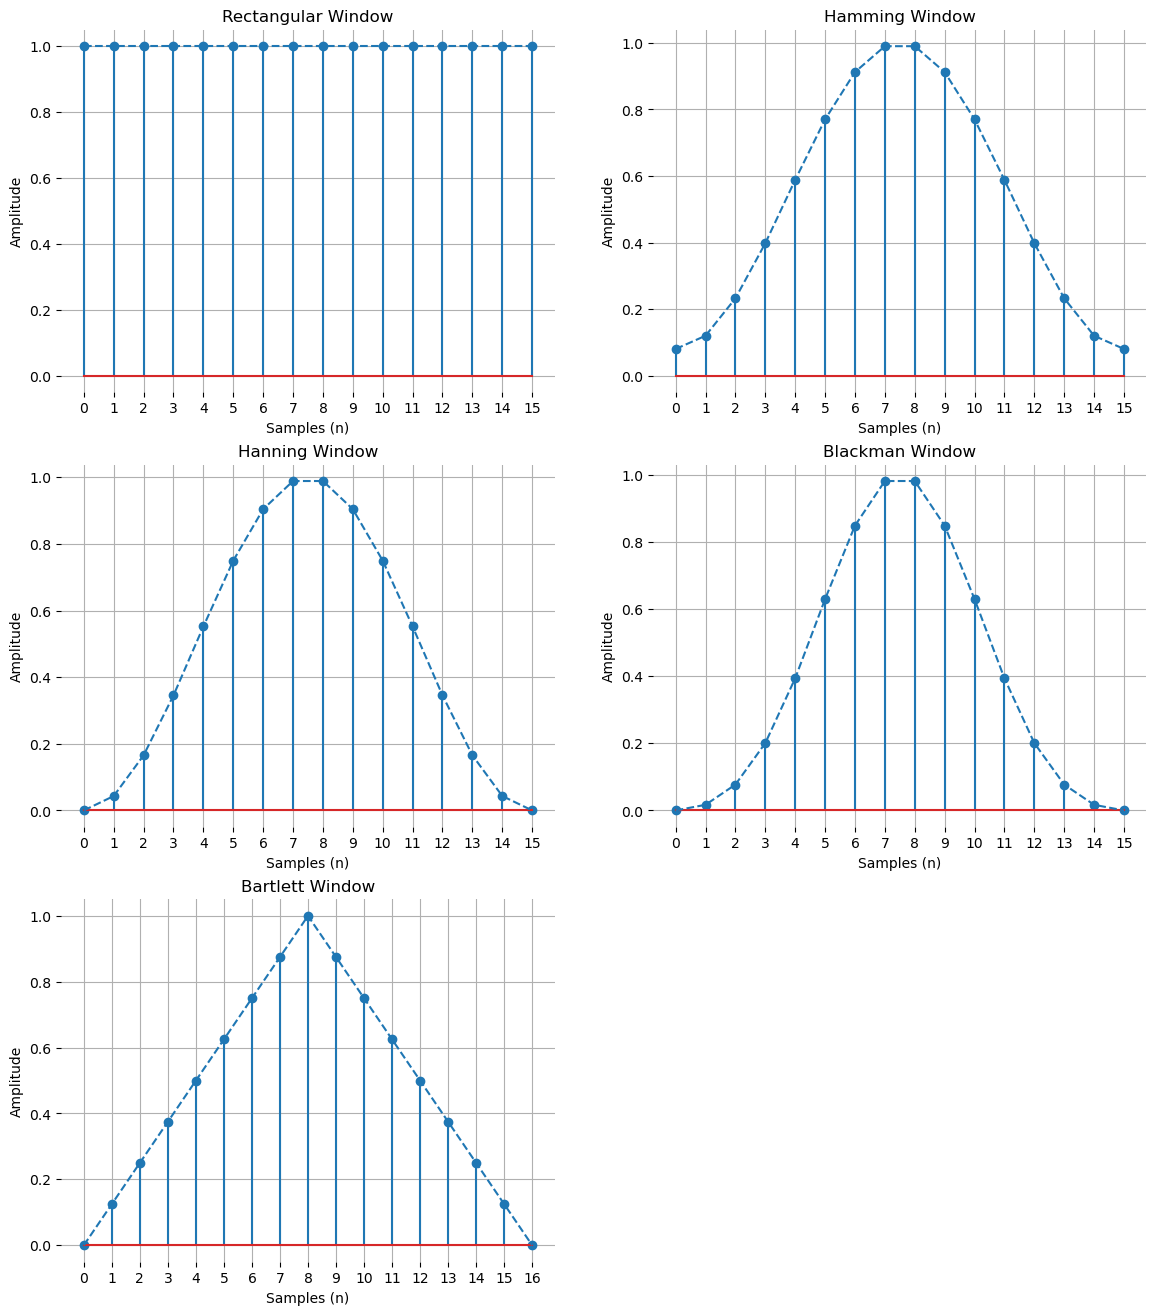

In [36]:
N = 16 # even number only
windows = ['ones', 'hamming', 'hanning', 'blackman', 'bartlett']
names = ['Rectangular', 'Hamming', 'Hanning', 'Blackman', 'Bartlett']

fig = plt.figure(figsize=(14, 16))

for idx, window in enumerate(windows):
    w = getattr(np, window)
    axes = fig.add_subplot(3, 2, idx+1)
    if window == 'bartlett':
        n = np.arange(0, N+1, 1)
        axes.stem(n, w(N+1), use_line_collection=True)
        axes.plot(n, w(N+1), linestyle='dashed')
    else:
        n = np.arange(0, N, 1)
        axes.stem(n, w(N), use_line_collection=True)
        axes.plot(n, w(N), linestyle='dashed')
    axes.grid(True, which='major')
    axes.set_xticks(n)
    axes.set_title(''.join([names[idx], ' Window']))
    axes.set_xlabel('Samples (n)')
    axes.set_ylabel('Amplitude')
    plt.box(False)

Each window has their own magnitude response in the frequency domain. These can be observed by running the following cell.

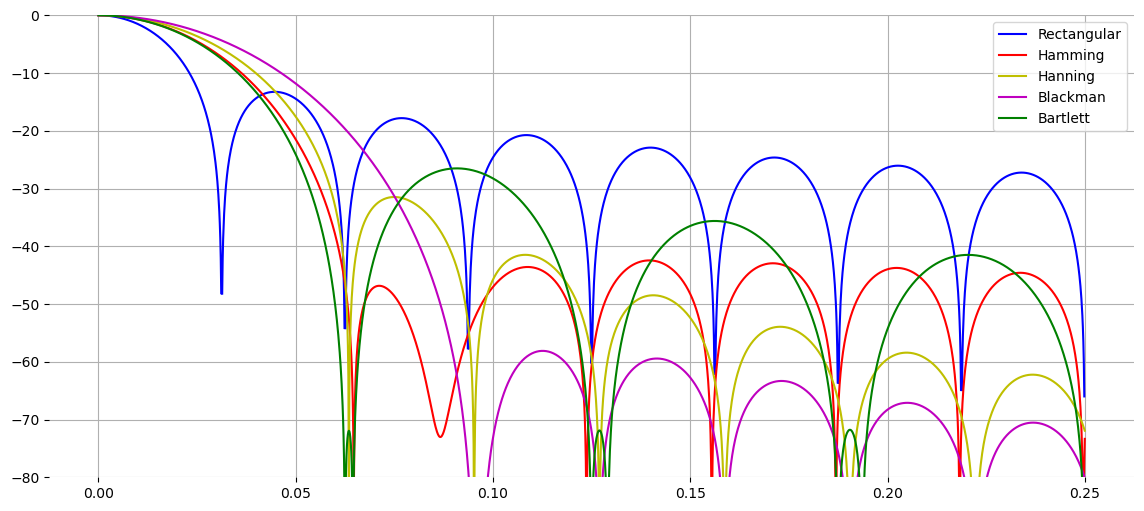

In [37]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

N = 64
Nc = 16384
fig = plt.figure(figsize=(14, 6))
axes = fig.add_subplot(1, 1, 1)
colours = ["b", "r", "y", "m", "g"]

for idx, window in enumerate(windows):
    w = getattr(np, window)
    Xw = np.fft.fft(np.pad(w(N), (0, Nc-N), 'constant'))
    Xwm = np.abs(Xw)
    Xwnorm = Xwm/np.sum(w(N))
    Xwlog = 20*np.log10(Xwnorm)
    axes.plot(np.arange(0, Nc//8+1, 1)/8192, Xwlog[0:Nc//8+1:1], colours[idx])
    axes.set_yticks(np.arange(0, -90, -10))
    axes.set_xticks(np.arange(0, N/(Nc/N)+0.05, 0.05))
    axes.set_ylim([-80, 0])
    axes.grid(True, which='major')
    axes.legend(names)
    plt.box(False)

Notice that the width of the rectangular window's primary lobe is the smallest of all windows above. However, the subsequent side lobes have very little suppression. The other tapered windows share a common trait of a wide primary lobe and suppressed side lobes (of different levels).

## 10. Scalloping Loss <a class="anchor" id="scalloping_loss"></a>
We can measure the worst-case reduction in energy when a discrete waveform contains a frequency component that resides precisely between two DFT bins. This measurement is known as Scalloping Loss (SL) [1] and is defined as

$$
\text{SL} = \frac{|\sum_{n}w(n)e^{-j\pi n/N}|}{\sum_{n}w(n)}.
$$

We can define a simple Python function that can measure the SL of any discrete window.

In [38]:
def scallop_loss(w):
    N = len(w)
    n = np.arange(0, N, 1)
    numerator = np.abs(np.sum(w*np.exp(-1j*np.pi*n/N)))
    decimator = np.sum(w)
    return numerator/decimator

Now, we can use the function to measure the SL of a rectangular window of length 16.

In [39]:
np.round(scallop_loss(np.ones(16)), 4)

0.6376

Similarly, the SL can be measured for a Hanning window of the same length.

In [40]:
np.round(scallop_loss(np.hanning(16)), 4)

0.8661

Notice that the SL for the rectangular window is worse than the SL for the Hanning window. The Hanning window has a wider main lobe than a rectangular window, so these results are expected.

You can compute the SL for any window using the function above. As an exercise, you can compute the SL for all windows, and determine the window that exhibits the best SL.

## 11. Zero Padding <a class="anchor" id="zero_padding"></a>
The final topic in this notebook is the zero padding technique, which is very useful when improving the frequency resolution of the DFT output. Consider the discrete waveform and its corresponding DFT output given in the cell below. The discrete wave was sampled using 2000Hz, the desired frequency is 250Hz, and it has 16 samples.

/var/folders/y_/4y9gzpnx6xx2bxstv0jtcl9h0000gn/T/ipykernel_12749/4018461594.py:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes.stem(x[idx], y[idx], use_line_collection = True)


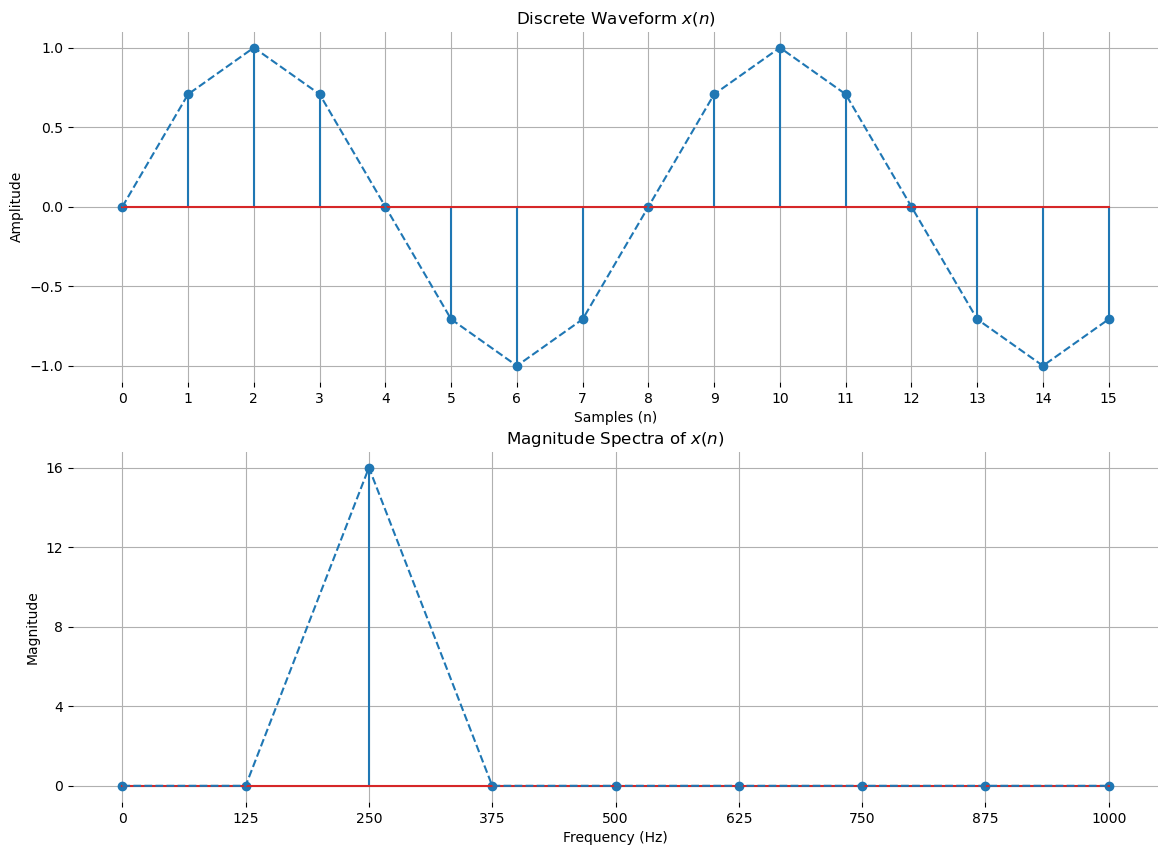

In [41]:
fs = 2000
ts = 1/fs
fd = 250
N = 16
n = np.arange(0, N, 1)
x = np.sin(2*np.pi*fd*ts*n)
Xm = np.round(np.abs(dft(x)), 2)*2

stem_plot(x      = [n, n[0:N//2+1:1]*(fs/N)],
          y      = [x, Xm[0:N//2+1]],
          subplot= (2, 1),
          figsize= (14, 10),
          style  = ["dashed", "dashed"],
          yticks = [np.arange(-1, 1+0.5, 0.5), np.arange(0, 20, 4)],
          xticks = [n, n[0:N//2+1:1]*fs/N],
          title  = ["Discrete Waveform $x(n)$", "Magnitude Spectra of $x(n)$"],
          xlabel = ["Samples (n)", "Frequency (Hz)"], 
          ylabel = ["Amplitude", "Magnitude"])

The frequency resolution of the DFT above is $\Delta f = 125\text{Hz}$. We can zero pad the end of the discrete wave with 16 zeros and then perform a 32-point DFT to improve the frequency resolution. This is implemented in the code cell below.

/var/folders/y_/4y9gzpnx6xx2bxstv0jtcl9h0000gn/T/ipykernel_12749/4018461594.py:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes.stem(x[idx], y[idx], use_line_collection = True)


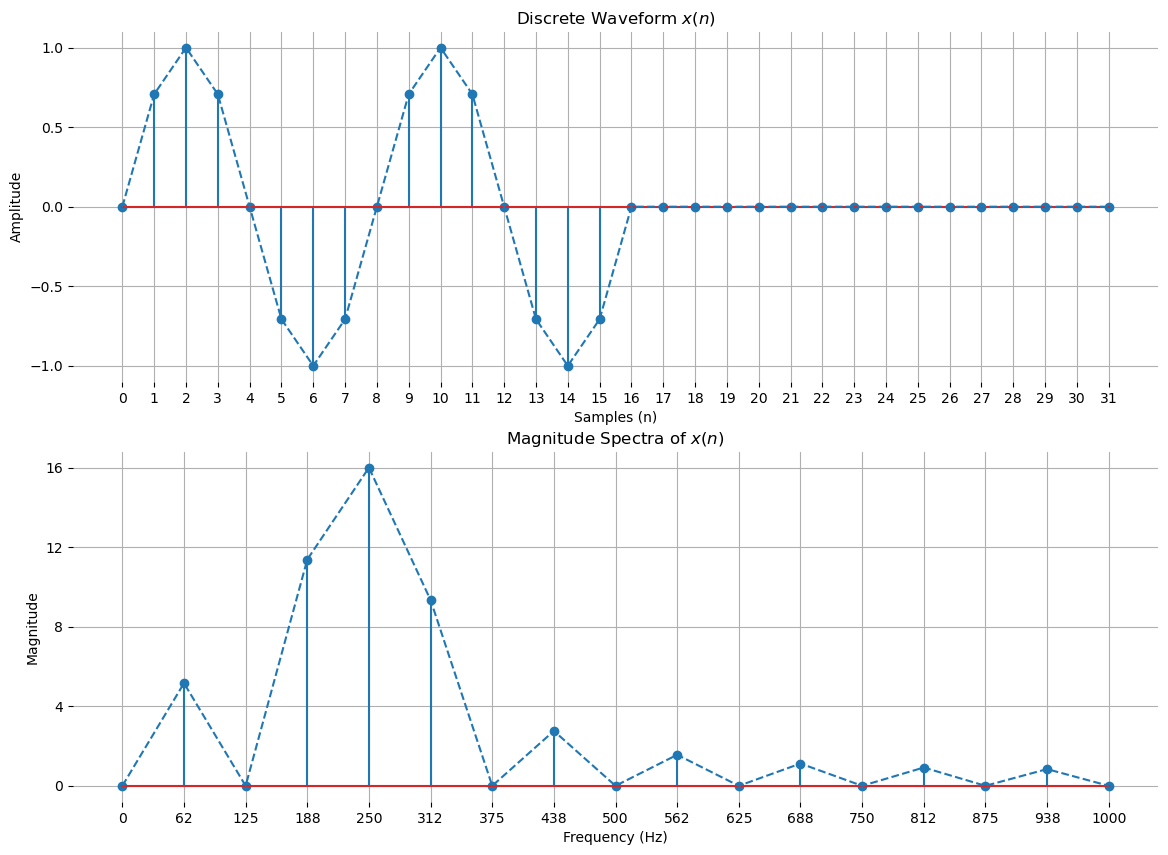

In [42]:
Nc = 32
n = np.arange(0, Nc, 1)
xp = np.pad(x, (0, Nc-N), 'constant')
Xm = np.round(np.abs(dft(xp)), 2)*2

stem_plot(x      = [n, n[0:Nc//2+1:1]*(fs/Nc)],
          y      = [xp, Xm[0:Nc//2+1]],
          subplot= (2, 1),
          figsize= (14, 10),
          style  = ["dashed", "dashed"],
          yticks = [np.arange(-1, 1+0.5, 0.5), np.arange(0, 20, 4)],
          xticks = [n, n[0:Nc//2+1:1]*fs/Nc],
          title  = ["Discrete Waveform $x(n)$", "Magnitude Spectra of $x(n)$"],
          xlabel = ["Samples (n)", "Frequency (Hz)"], 
          ylabel = ["Amplitude", "Magnitude"])

Notice that the frequency resolution has increased to $\Delta f = 62.5\text{Hz}$. We can append another 16 zeros to the end of the signal to improve the frequency resolution further, as follows.

/var/folders/y_/4y9gzpnx6xx2bxstv0jtcl9h0000gn/T/ipykernel_12749/4018461594.py:10: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes.stem(x[idx], y[idx], use_line_collection = True)


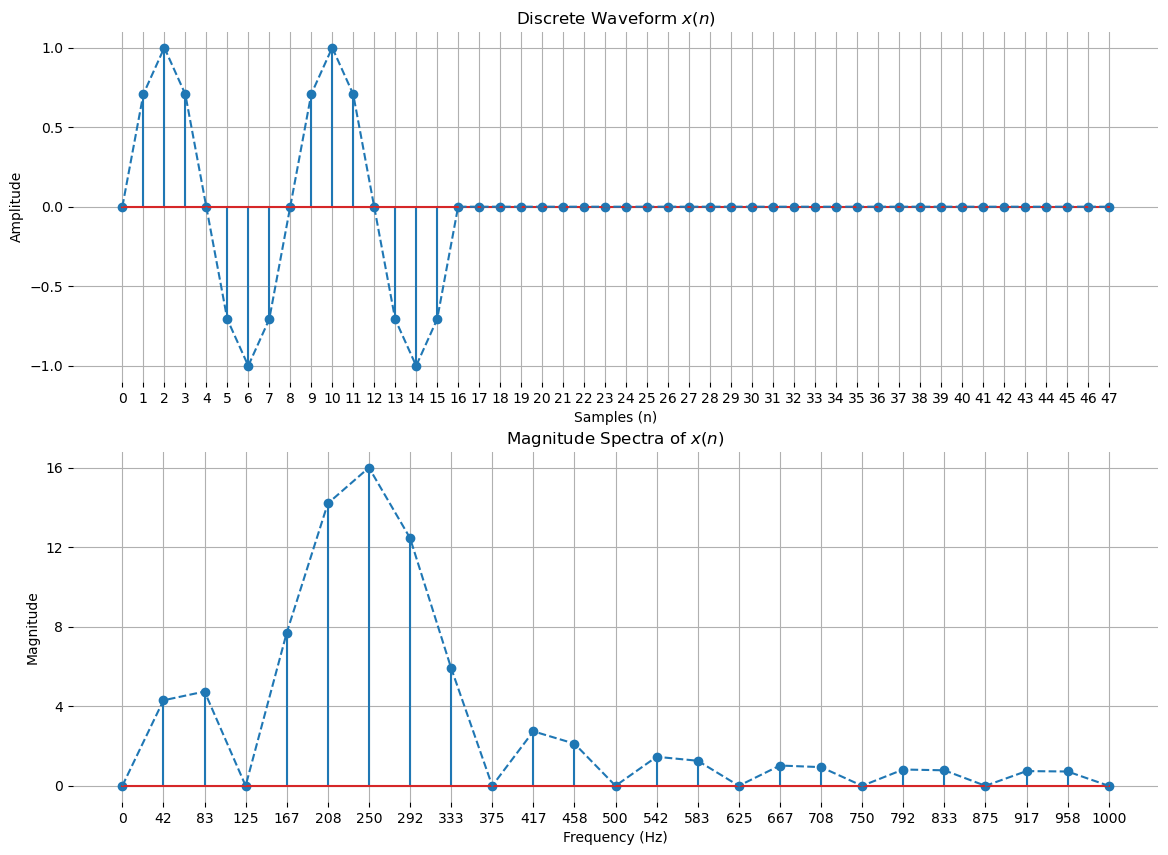

In [43]:
Nc = 48
n = np.arange(0, Nc, 1)
xp = np.pad(x, (0, Nc-N), 'constant')
Xm = np.round(np.abs(dft(xp)), 2)*2

stem_plot(x      = [n, n[0:Nc//2+1:1]*(fs/Nc)],
          y      = [xp, Xm[0:Nc//2+1]],
          subplot= (2, 1),
          figsize= (14, 10),
          style  = ["dashed", "dashed"],
          yticks = [np.arange(-1, 1+0.5, 0.5), np.arange(0, 20, 4)],
          xticks = [n, n[0:Nc//2+1:1]*fs/Nc],
          title  = ["Discrete Waveform $x(n)$", "Magnitude Spectra of $x(n)$"],
          xlabel = ["Samples (n)", "Frequency (Hz)"], 
          ylabel = ["Amplitude", "Magnitude"])

Notice that the output magnitude spectra now has a frequency resolution of $\Delta f = 41.67\text{Hz}$.

Keep in mind that zero padding has the effect of improving the frequency resolution of the DFT, but increases its computational requirements.

[⬅️ Previous Notebook](05_fouriers_theorem.ipynb) || [Next Notebook 🚀](07_fast_fourier_transform.ipynb)
